In [9]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import warnings
warnings.filterwarnings('ignore')
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In [10]:
import matplotlib.pyplot as plt
# function to plot the training/validation accuracies/losses.

def plot_data(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['categorical_accuracy','val_categorical_accuracy'])

In [11]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 60 #experiment with the batch size

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [13]:
x = 30 # Total images in one sequence
y = 120 # height
z = 120 # width
channel = 3 
classes = 5

In [14]:
def generator_all(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Taking every 5th image as consecutive images are similar. Making sure last image is always there.
    img_idx = [x for x in range(0,x,5)] #create a list of image numbers you want to use for a particular video
    img_idx.append(29)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        num_batches_range = num_batches
        if(len(folder_list) < batch_size):
            batch_size = len(folder_list)
            num_batches_range = 1
        for batch in range(num_batches_range): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,7,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = imresize(image,(y,z))
                    # Normalizing by 95 percentile
                    temp = (temp - np.percentile(temp,5)) / (np.percentile(image,95) - np.percentile(temp, 5))
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if ((len(folder_list) != batch_size*num_batches) and (num_batches > 0)):
            batch = num_batches
            batch_size_new = len(folder_list) - (batch_size*num_batches)
            print("Batch: ",num_batches+1,"Index:", batch_size_new)
            batch_data = np.zeros((batch_size_new,7,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size_new,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size_new): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    # Normalizing by 95 percentile
                    temp = (temp - np.percentile(temp,5)) / (np.percentile(image,95) - np.percentile(temp, 5))
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [15]:
# Taking every 5th image as consecutive images are similar. Making sure last image is always there.
images_used = [x for x in range(0,30, 5)] #create a list of image numbers you want to use for a particular video
images_used.append(29)
images_used = len(images_used)

### CNN 2d + GRU + Transfer learning using MobileNet

In [16]:
from keras.applications import MobileNet

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, Input, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras

base_model = Sequential()
base_model.add(TimeDistributed(MobileNet(weights='imagenet',include_top=False), input_shape=(images_used,y,z,channel)))
base_model.add(TimeDistributed(GlobalAveragePooling2D()))
base_model.add(TimeDistributed(BatchNormalization()))
base_model.add(TimeDistributed(Dense(1024,activation='relu')))
base_model.add(TimeDistributed(Flatten()))
base_model.add(GRU(128))
base_model.add(Dropout(0.5))
base_model.add(Dense(64, activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.0002)
base_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

W0308 14:19:23.669143 139645275506496 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


In [17]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 7, 3, 3, 1024)     3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1024)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 1024)           4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 1024)           1049600   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 7, 1024)           0         
_________________________________________________________________
gru (GRU)                    (None, 128)               443136    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [18]:
train_generator = generator_all(train_path, train_doc, batch_size)
val_generator = generator_all(val_path, val_doc, batch_size)

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [LR, checkpoint]

W0308 14:20:24.407132 139645275506496 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [21]:
base_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0308 14:20:27.307379 139645275506496 deprecation.py:323] From <ipython-input-21-212fdea27980>:3: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


Source path =  Project_data/train ; batch size = 60
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 1.7822 - categorical_accuracy: 0.2655Source path =  Project_data/val ; batch size = 60
Batch:  2 Index: 40

Epoch 00001: val_loss improved from inf to 1.44517, saving model to model_init_2021-03-0814_19_13.819926/model-00001-1.78225-0.26546-1.44517-0.44000.h5
12/12 [==============================] - 30s 3s/step - loss: 1.7822 - categorical_accuracy: 0.2655 - val_loss: 1.4452 - val_categorical_accuracy: 0.4400 - lr: 2.0000e-04
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 1.2084 - categorical_accuracy: 0.5173Batch:  2 Index: 40
Batch:  2 Index: 40

Epoch 00002: val_loss improved from 1.44517 to 1.18112, saving model to model_init_2021-03-0814_19_13.819926/model-00002-1.20842-0.51735-1.18112-0.55000.h5
12/12 [==============================] - 29s 2s/step - loss: 1.2084 - categorical_accuracy: 0.5173 - val_loss: 1.1811 - val_categorical_accuracy: 0.

Epoch 16/30
12/12 [==============================] - ETA: 0s - loss: 0.1564 - categorical_accuracy: 0.9563Batch:  2 Index: 40
Batch:  2 Index: 40

Epoch 00016: val_loss did not improve from 0.51830
12/12 [==============================] - 29s 2s/step - loss: 0.1564 - categorical_accuracy: 0.9563 - val_loss: 0.5219 - val_categorical_accuracy: 0.7800 - lr: 2.5000e-05
Epoch 17/30
12/12 [==============================] - ETA: 0s - loss: 0.1526 - categorical_accuracy: 0.9608Batch:  2 Index: 40

Epoch 00017: val_loss improved from 0.51830 to 0.47958, saving model to model_init_2021-03-0814_19_13.819926/model-00017-0.15264-0.96078-0.47958-0.82000.h5
12/12 [==============================] - 30s 3s/step - loss: 0.1526 - categorical_accuracy: 0.9608 - val_loss: 0.4796 - val_categorical_accuracy: 0.8200 - lr: 2.5000e-05
Epoch 18/30
12/12 [==============================] - ETA: 0s - loss: 0.1490 - categorical_accuracy: 0.9623Batch:  2 Index: 40
Batch:  2 Index: 40

Epoch 00018: val_loss improved f

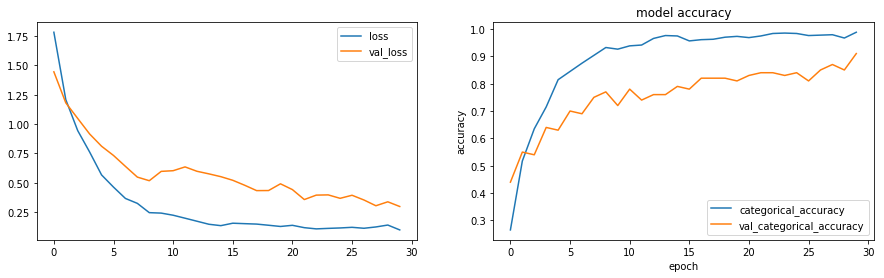

In [23]:
plot_data(base_model.history)